Using device: cuda
EuroSAT dataset not found locally. Downloading...


100%|██████████| 94.3M/94.3M [00:00<00:00, 373MB/s]


Found 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Epoch [1/10] -> Train Loss: 0.6511, Train Acc: 79.36% | Val Loss: 1.0787, Val Acc: 73.58%
Epoch [2/10] -> Train Loss: 0.3938, Train Acc: 89.47% | Val Loss: 0.3753, Val Acc: 88.15%
Epoch [3/10] -> Train Loss: 0.2766, Train Acc: 91.74% | Val Loss: 0.2643, Val Acc: 92.22%
Epoch [4/10] -> Train Loss: 0.2428, Train Acc: 92.78% | Val Loss: 0.4334, Val Acc: 88.15%
Epoch [5/10] -> Train Loss: 0.2942, Train Acc: 90.90% | Val Loss: 0.3177, Val Acc: 91.11%
Epoch [6/10] -> Train Loss: 0.2038, Train Acc: 93.86% | Val Loss: 0.2421, Val Acc: 91.11%
Epoch [7/10] -> Train Loss: 0.2037, Train Acc: 93.49% | Val Loss: 0.7472, Val Acc: 80.74%
Epoch [8/10] -> Train Loss: 0.2529, Train Acc: 93.86% | Val Loss: 0.3952, Val Acc: 88.52%
Epoch [9/10] -> Train Loss: 0.3399, Train Acc: 91.00% | Val Loss: 1.0030, Val Acc: 77.65%
Epoch [10/10] -> Train Loss: 0.2002, Train Acc: 93.54% | Val Loss: 0.1409, Val Acc: 94.69%

Classification Report:
                      precision    recall  f1-score   support

          An

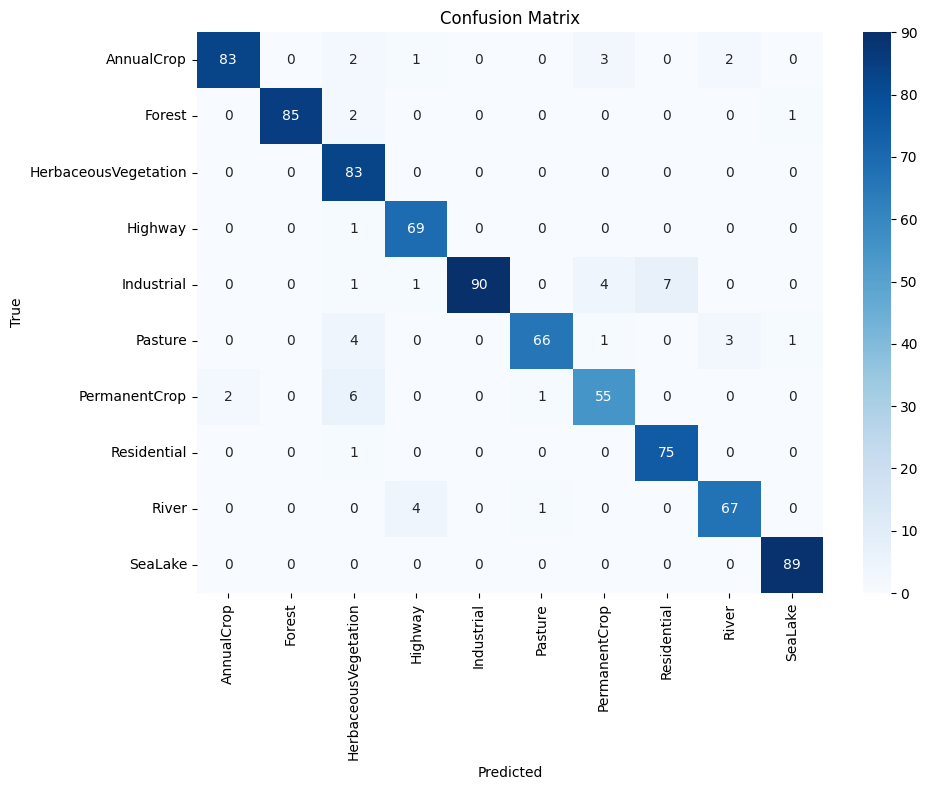

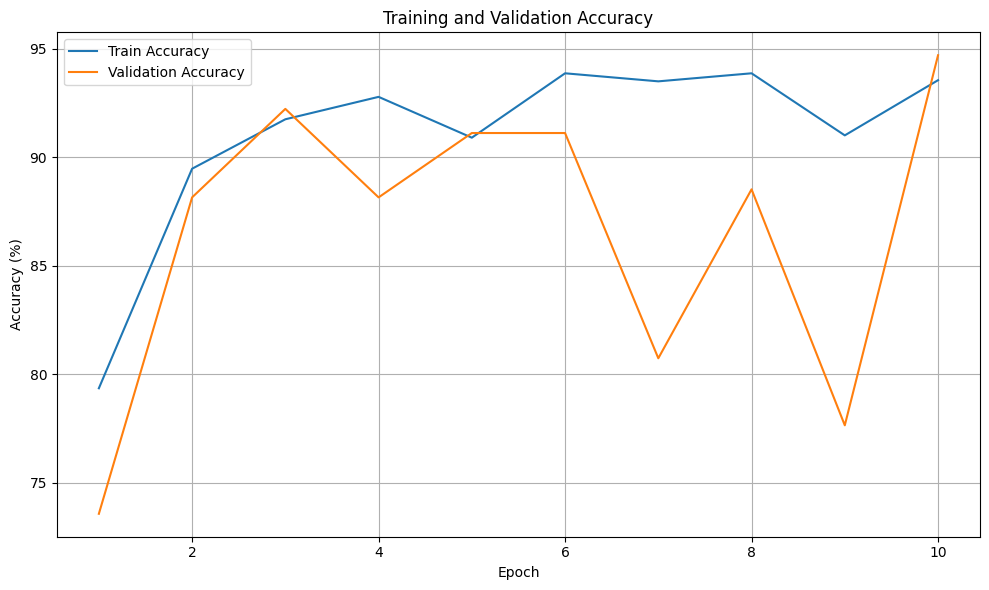

Model saved as resnet18_eurosat.pth


In [1]:
# Note: This script requires PyTorch, Torchvision, scikit-learn, seaborn, and matplotlib to be installed.
# Install them using: pip install torch torchvision scikit-learn seaborn matplotlib

# Import libraries
import os

try:
    import torch
    import torchvision
    import torch.nn as nn
    import torch.optim as optim
    from torchvision import datasets, models, transforms
    from torch.utils.data import DataLoader, random_split
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    from torchvision.models import resnet18, ResNet18_Weights
except Exception as e:
    print("Error importing required libraries:", e)
    print("Make sure to install required libraries using:\n")
    print("pip install torch torchvision scikit-learn seaborn matplotlib")
    raise

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data directory
data_dir = "./EuroSAT"

# Define transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load dataset
if not os.path.exists(data_dir):
    print("EuroSAT dataset not found locally. Downloading...")
    dataset = torchvision.datasets.EuroSAT(root='./', download=True, transform=transform['train'])
else:
    dataset = datasets.ImageFolder(data_dir, transform=transform['train'])

# Class names
class_names = dataset.classes
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Reduce dataset size for faster training (20% subset)
small_dataset, _ = random_split(dataset, [int(0.2 * len(dataset)), len(dataset) - int(0.2 * len(dataset))])

# Split small dataset: 70% train, 15% val, 15% test
train_size = int(0.7 * len(small_dataset))
val_size = int(0.15 * len(small_dataset))
test_size = len(small_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(small_dataset, [train_size, val_size, test_size])

# Update transforms for val and test sets
val_set.dataset.transform = transform['test']
test_set.dataset.transform = transform['test']

# Data loaders
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet18
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation after each epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = 100 * val_correct / val_total

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

# Evaluation on test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), "resnet18_eurosat.pth")
print("Model saved as resnet18_eurosat.pth")
